In [268]:
import os
import numpy as np
import scipy.io as scio
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import importlib

In [3]:
import utils

In [4]:
importlib.reload(utils.display)

<module 'utils.display' from 'e:\\Projects\\LiveGestureUseDepthCamera\\utils\\display.py'>

In [220]:

FINGER_COLORS_CC = [
    [  255,255,255   ],
    # 1
    [  255,50,50  ],
    [  255,100,100 ],
    [  255,150,150 ],
    [  255,200,200 ],
    # 2
    [  255,255,50  ],
    [  255,255,100  ],
    [  255,255,150  ],
    [  255,255,200   ],
    #3
    [  50,255,50 ],
    [  100,255,100 ],
    [  150,255,150 ],
    [  200,255,200 ],
    #4
    [  50,255,255  ],
    [  100,255,255  ],
    [  150,255,255   ],
    [  200,255,255  ],
    #5
    [  50,50,255  ],
    [  100,100,255  ],
    [  150,150,255  ],
    [  200,200,255   ]]

In [221]:
sample_correct = np.load("./data/sample.npy")
sample_error = np.load("./data/errsample.npy")

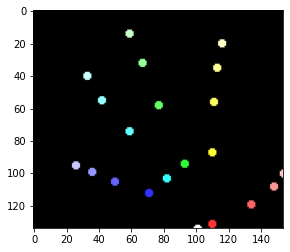

In [222]:
img_correct = utils.display.drawResult(sample_correct,colorMap= FINGER_COLORS_CC)
plt.imshow(img_correct)

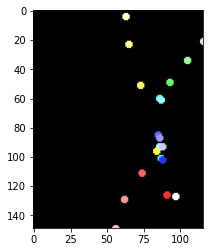

In [296]:
img_error = utils.display.drawResult(sample_error,colorMap= FINGER_COLORS_CC)
plt.imshow(img_error)

In [301]:
FINGER_THUMB  = [0,1,2,3,4]
FINGER_INDEX  = [0,5,6,7,8]
FINGER_MIDDLE = [0,9,10,11,12]
FINGER_RING   = [0,13,14,15,16]
FINGER_PINKY  = [0,17,18,19,20]
FINGERS = np.array([FINGER_THUMB,FINGER_INDEX, FINGER_MIDDLE, FINGER_RING,FINGER_PINKY ])
def drawAngle(image,landmark, feangleList,AbductionAdductionAngleList=None):
    for i in range(5):
        for j in range(3):
            pos = landmark[FINGERS[i][j+1]]
            cv2.putText(image,str(np.round(feangleList[i][j],2)),np.int32(pos[:2]),0,0.3,(255,255,255),1)
    if AbductionAdductionAngleList is not None:
        cv2.putText(image,str(np.round(AbductionAdductionAngleList[0],2)),np.int32(landmark[1][:2]),0,0.3,(255,0,0),1)
        cv2.putText(image,str(np.round(AbductionAdductionAngleList[1],2)),np.int32(landmark[5][:2]),0,0.3,(255,0,0),1)
        cv2.putText(image,str(np.round(AbductionAdductionAngleList[2],2)),np.int32(landmark[9][:2]),0,0.3,(255,0,0),1)
        cv2.putText(image,str(np.round(AbductionAdductionAngleList[3],2)),np.int32(landmark[13][:2]),0,0.3,(255,0,0),1)
        cv2.putText(image,str(np.round(AbductionAdductionAngleList[4],2)),np.int32(landmark[2][:2]),0,0.3,(255,0,0),1)
    return image
def getCoord(a,b,c):
    ab = b-a
    ac = c-a
    yd = np.cross(ab,ac)
    y = yd/np.linalg.norm(yd)
    x = ab/np.linalg.norm(ab)
    zd = np.cross(x,y)
    z = zd/np.linalg.norm(zd)
    return np.array([x,y,z])
def getHandCoord(landmark):
    a = landmark[0]
    b = landmark[5]
    c = landmark[17]
    return getCoord(a,b,c)

def convertToHandCoord(landmark):
    coord = getHandCoord(landmark)
    invCoord = np.linalg.inv(coord)
    landmarkHandCoord = np.matmul(landmark,invCoord)
    return landmarkHandCoord

def get3DCosAngle(a,b):
    return np.arccos((np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))

def get3DAngleDeg(a:np.ndarray,b:np.ndarray,axis:np.ndarray=None):
    angle = np.rad2deg(get3DCosAngle(a,b))
    if axis is not None:
        axb = np.cross(a,b)
        axb /= np.linalg.norm(axb)
        dirc = np.dot(axis,axb)
        if dirc<0:
            angle = -angle
    return float(angle)

def get3DAngleDegByPlane(vec:np.ndarray,pa:np.ndarray,pb:np.ndarray):
    pab = np.cross(pa,pb) 
    angle = 90-np.rad2deg(get3DCosAngle(vec,pab))
    if np.dot(vec,pab)<0:
        angle = -angle

    return angle

def getFlexionExtensionAngleList(landmark):
    angle_list = [None]*5
    thumbAxis =  landmark[5] -landmark[1]
    thumbAxis/= np.linalg.norm(thumbAxis)
    thumb = FINGERS[0]
    vecList = landmark[thumb[1:]]-landmark[thumb[:4]]
    thumbCMC =  get3DAngleDegByPlane(vecList[1],landmark[5]-landmark[0],vecList[0]) 
    thumbMCP = get3DAngleDeg(vecList[1],vecList[2],thumbAxis)
    thumbIP = get3DAngleDeg(vecList[2],vecList[3],thumbAxis)
    angle_list[0] =[thumbCMC,thumbMCP,thumbIP]
    
    handAxis =  landmark[17]-landmark[5]
    handAxis/= np.linalg.norm(handAxis)
    for i in range(1,5):
        finger = FINGERS[i]
        vecList = landmark[finger[1:]]-landmark[finger[:4]]
        for v in range(3):
            vecList[v]/= np.linalg.norm(vecList[v])
        angleMCP = get3DAngleDeg(vecList[0],vecList[1],handAxis)
        anglePIP = get3DAngleDeg(vecList[1],vecList[2],handAxis)
        angleDIP = get3DAngleDeg(vecList[2],vecList[3],handAxis)
        angle_list[i] = [angleMCP,anglePIP,angleDIP]
    return angle_list

def getAbductionAdductionAngleList(landmark):
    angle_list = [None]*5
    axis = np.cross(landmark[5]-landmark[0],landmark[17]-landmark[0])
    axis/= np.linalg.norm(axis)
    for i in range(4):
        finger1 = FINGERS[i]
        finger2 = FINGERS[i+1]
        vec1 = landmark[finger1[1]]-landmark[0]
        vec2 = landmark[finger2[1]]-landmark[0]
        angle_list[i] = get3DAngleDeg(vec1,vec2,axis)
    # angle_list[5] = 
    
    
    v1 = landmark[2]-landmark[1]
    v2 = landmark[5]-landmark[1]
    axis = np.cross(v1,v2)
    angle_list[4] = get3DAngleDeg(v1,v2,axis)
    
    return angle_list

In [302]:
getFlexionExtensionAngleList(sample_correct)

[[37.314444552644005, -7.34428186003337, -12.529728992903495],
 [-16.313920466153053, 6.108609429811095, -6.677550111294907],
 [9.229379435893417, 3.662187679031558, -1.1729332162532904],
 [5.269551887778151, 3.687305032233784, -8.961497146109378],
 [-14.436865291610738, 5.849619112962991, -7.789778736492644]]

In [303]:
getAbductionAdductionAngleList(sample_correct)

[85.59226084094422,
 18.507063508784817,
 13.586666403028522,
 13.9768961134187,
 40.60246087538546]

In [236]:

rz = 0.1
rotateMatZ = np.eye(4)
rotateMatZ[:2,:2] = np.array([
    [np.cos(rz),-np.sin(rz)],
    [np.sin(rz),np.cos(rz)]
])
rx = 0.1
rotateMatX = np.eye(4)
rotateMatX[1:3,1:3] = np.array([
    [np.cos(rx),-np.sin(rx)],
    [np.sin(rx),np.cos(rx)]
])
ry = 0.1
rotateMatY = np.eye(4)
rotateMatY[[0,2],[[0,0],[2,2]]]  = np.array([
    [np.cos(ry),-np.sin(ry)],
    [np.sin(ry),np.cos(ry)]
]).T
rotateMat = np.matmul(np.matmul(rotateMatZ,rotateMatX),rotateMatY)

[85.59226084094422, 18.507063508784817, 13.586666403028522, 13.9768961134187, 40.60246087538546]


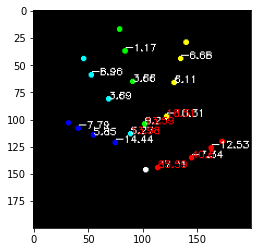

In [313]:
image = np.zeros((200,200,3), np.uint8)
sample_center=(sample_correct-(88,88,0))/(88,88,150)
sample_center = utils.math.applyTrans(sample_center,rotateMat)
landmark = (sample_center+0.5)*100 +50
feangleList = getFlexionExtensionAngleList(sample_correct)
aaanglelist = getAbductionAdductionAngleList(sample_correct)
img_correct = utils.display.drawResult(landmark,image)
img_correct = drawAngle(img_correct,landmark, feangleList,aaanglelist)
print(aaanglelist)
plt.imshow(img_correct)

In [238]:
coord = getHandCoord(sample_correct-(88,88,0))

In [304]:
getAbductionAdductionAngleList(sample_correct)

[85.59226084094422,
 18.507063508784817,
 13.586666403028522,
 13.9768961134187,
 40.60246087538546]

In [ ]:
# https://doi.org/10.3389/frvir.2021.663618

# AA =  abduction_and_adduction 外展内缩
# FE = flexion_and_extension 屈伸 
Thumb_CMC_AA = [45 ,0]
Thumb_MCP_AA = [12,-7]

Thumb_CMC_FE = [45,-20]
Thumb_MCP_FE = [80 ,0]
Thumb_IP_FE  = [90,-30]

MCP_AA       = [15,8]
PIP_AA       = [15,-15]
MCP_FE       = [90,-40]
PIP_FE       = [130,0]
DIP_FE       = [90,-30]

In [ ]:

    
def redirectVector(vec1,vec2,axis,angle,constrain):
    if (angle>0 and angle<=constrain[0]) or (angle<=0 and angle>= constrain[1]) :
        return vec1
    if (angle>0 and angle>constrain[0]):
        angle = constrain[0]
    elif (angle<=0 and angle<= constrain[1]) :
        angle = constrain[1]

    # n = np.cross(vec1,vec2)
    # n/= np.linalg.norm(n)
    # if np.dot(n,axis)<0:
    #     n = -n
    vec = vec2/np.linalg.norm(vec2) *np.linalg.norm(vec1)
    coord = getCoord(np.array([0,0,0],vec1,vec2))
    invCoord = np.linalg.inv(coord)
    vec_ = np.matmul(vec,invCoord)
    
    rotateMatZ = np.eye(4)
    rotateMatZ[:2,:2] = np.array([
        [np.cos(rz),-np.sin(rz)],
        [np.sin(rz),np.cos(rz)]
    ])
    
    rotate=np.array()
    
    pass

def constrainHand(landmark):
    pass